In [20]:
import numpy as np
from scipy import signal
from sklearn.decomposition import PCA, FastICA
import matplotlib.pyplot as plt


In [21]:
np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(1 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal
s4 = signal.sawtooth(2 * np.pi * time, 0.5)  # Triangular wave



S = np.c_[s1, s2, s4]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
# # Mixing matrix 行对应混合信号，列对应原始信号
# A = np.array([[1, 1, 1, 1], [0.5, 4, 1.0, 2], [1.5, 1.0, 4.0, 0], 
#               [4, 0, 1, 3], [2, 3, 4, 6], [5,4,3,2]])  
A = np.array([[1, 1, 1], [0.5, 4, 1.0], [1.5, 1.0, 4.0], 
              [4, 2.5, 1], [2, 3, 4], [5,4,3]])
X = np.dot(S, A.T)  # Generate observations


In [22]:
# fastICA
ica = FastICA(n_components=3, whiten="arbitrary-variance")
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

# We can `prove` that the ICA model applies by reverting the unmixing.
assert np.allclose(X, np.dot(S_, A_.T) + ica.mean_)


In [23]:
# PCA
pca = PCA(n_components=3)
H = pca.fit_transform(X)  # Reconstruct signals based on orthogonal components


In [24]:
# jader
from jadeR import jadeR
Xt= X.T
demix_matrix=np.asarray(jadeR(Xt, m=3, verbose=True))
IC = demix_matrix @ Xt


jade -> Looking for 3 sources
jade -> Removing the mean value
jade -> Whitening the data
jade -> Estimating cumulant matrices
jade -> Contrast optimization by joint diagonalization
jade -> Sweep #  0
completed in 3 rotations
jade -> Sweep #  1
completed in 3 rotations
jade -> Sweep #  2
completed in 3 rotations
jade -> Sweep #  3
completed in 1 rotations
jade -> Sweep #  4
completed in 0 rotations
jade -> Total of 10 Givens rotations
jade -> Sorting the components
jade -> Fixing the signs


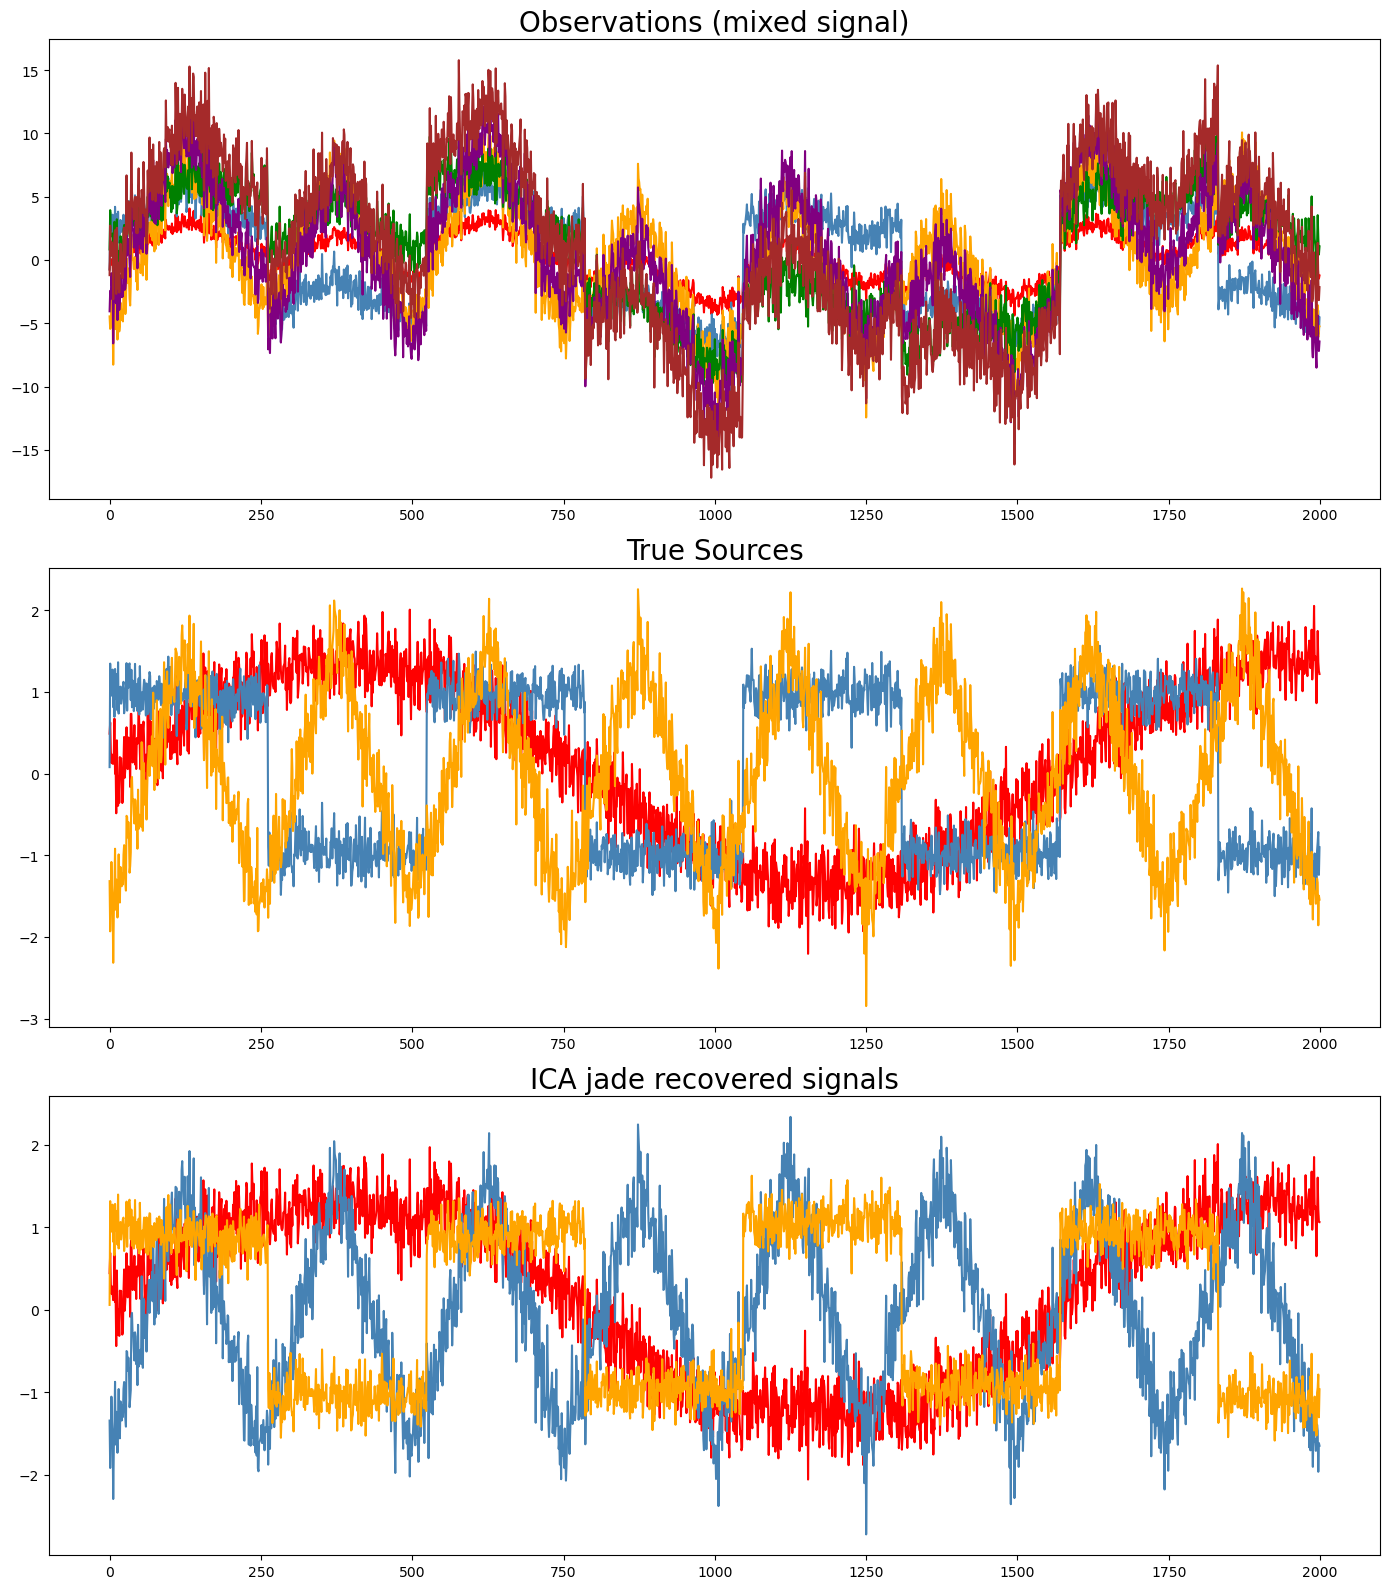

In [25]:
# plot
plt.figure(figsize=(14, 16))

# models = [X, S, IC.T, S_, H]
models = [X, S, IC.T]

names = [
    "Observations (mixed signal)",
    "True Sources",
    "ICA jade recovered signals",
    # "fastICA recovered signals",
    # "PCA recovered signals",
]
colors = ["red", "steelblue", "orange", "green", 'purple', 'brown']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(3, 1, ii)
    plt.title(name,fontsize=20)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.tight_layout()
plt.savefig('ICA results comparison.png')
plt.show()



### determine the optimal number of independent components

In [26]:
# DW criterion

def calculate_DW(e):
    numerator = np.sum((e[1:] - e[:-1]) ** 2)
    denominator = np.sum(e ** 2)
    DW = numerator / denominator
    return DW

def DW_ICA(X, min_IC=2, max_IC=None, nIC_step=1, verbose=False):
    N = X.shape[0]
    if max_IC == None: max_IC=N
    
    DW_values = []
    for n_IC in range(min_IC, max_IC, nIC_step):
        print(f'\ntest n_IC = {n_IC}')
        demix_matrix = jadeR(X, m=n_IC, verbose=verbose)
        IC = demix_matrix @ X

        Xk = np.linalg.pinv(demix_matrix) @ IC
        Rk = X - Xk
        DW_sample_values = [calculate_DW(np.asarray(Rk[i, :]).ravel()) for i in range(N)]
        DW_values.append(DW_sample_values)
        print(f"DW: {DW_sample_values}")

    IC_num = range(min_IC, max_IC, nIC_step)

    return IC_num, np.asarray(DW_values)
        


test n_IC = 2
DW: [0.11082839358386216, 0.11082839358386361, 0.11082839358386332, 0.1108283935838634, 0.11082839358386401, 0.11082839358386337]

test n_IC = 3
DW: [0.16622181435934585, 0.23119240799932542, 0.17315957530507683, 0.38171828384422996, 0.32368262851919954, 0.8839522817618783]

test n_IC = 4
DW: [0.356618077985, 1.8776982419556671, 1.9445821842656168, 1.7554043392644008, 0.9993962745354563, 0.8572290580594131]

test n_IC = 5
DW: [0.4701123594185449, 0.5386545008223161, 0.7013205734541594, 0.2986442904225097, 0.6205597563761434, 0.38425955946074614]


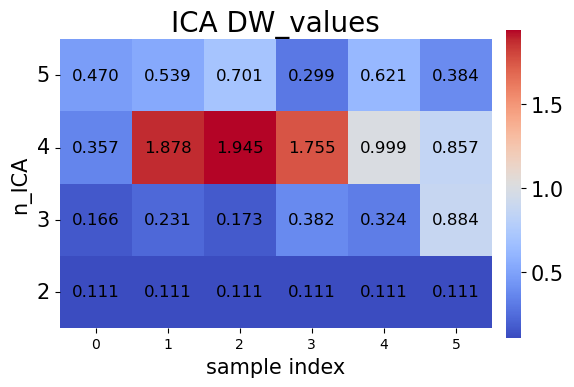

In [27]:
from NatMovie_utils import plot_heatmap

Xt= X.T
IC_num, DW_value = DW_ICA(Xt)
plot_heatmap(DW_value, xlabel=None, ylabel=IC_num, xtitle='sample index', ytitle='n_ICA', cmap='coolwarm', title='ICA DW_values', outfile=None)


In [28]:
# The LCC algorithm   

def LCC_ICA(X, min_IC=2, max_IC=None, nIC_step=1, verbose=False):
    N = X.shape[0]
    if max_IC == None: max_IC=N-1

    for n_IC in range(min_IC, max_IC, nIC_step):
        print(f'\ntest n_IC = {n_IC}')
        demix_matrix=jadeR(X, m=n_IC, verbose=verbose)
        IC = demix_matrix @ X
#
        corr_matrix = np.corrcoef(IC)
        np.fill_diagonal(corr_matrix, 0)
        if np.max(np.abs(corr_matrix)) > 0.1:
            k = n_IC - 1
            print(f'\n\nk = {k}')
            selected_demix_matrix=jadeR(X, m=k, verbose=False)
            selected_IC = selected_demix_matrix @ X
            print(f'finish LCC_algorithm')
            return k, selected_IC, selected_demix_matrix
        


In [29]:

Xt= X.T
k, ICs, demix_matrix = LCC_ICA(Xt)
print(f'Optimal IC number: {k}')



test n_IC = 2

test n_IC = 3

test n_IC = 4


k = 3
finish LCC_algorithm
Optimal IC number: 3


### natural movie data test ICA

In [2]:
from jadeR import jadeR
from jadeR_cupy import jadeR_cupy
import pandas as pd
from wfield import *
import pickle
import sys
import os
# sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append('..')
from NatMovie_utils import *
from os.path import join as pjoin
from glob import glob

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import cupy as cp

In [ ]:
path_wfield = r'/home/lzx/data/WF_VC_liuzhaoxi/24.07.08_Q20/natural-movie/process/20240708-175712-wfield'
experiment = os.path.basename(path_wfield)[:15]
mouse = os.path.normpath(path_wfield).split(os.sep)[5].split('_')[1]
path_out = pjoin(path_wfield, '..', experiment + '-natural-movie')
os.makedirs(path_out, exist_ok=True)
print(experiment,mouse)
trialfile = pd.read_csv(pjoin(path_wfield, 'trials.csv'), header=None).values.astype(int)
rawPath = pjoin(path_wfield, '../../raw')
movie_folder = pjoin(rawPath, 'natural_movies')
movie_list = pd.read_csv(pjoin(movie_folder, 'movie_list.txt'), header=None).values
n_movie = movie_list.size
movie_name_list = []
for imovie in range(n_movie):
    movie_name_list.append(str(movie_list[imovie])[2:-6])
n_frame = 150  # 帧

frames_average = np.load(pjoin(path_wfield, 'frames_average.npy')).astype('float32')
pre_length = 20
after_lenth = 30
whole_length = trialfile[-1, 2]+50



20240708-175712 Q20


In [ ]:

if os.path.exists(pjoin(path_out, 'tif_sort.npy')):
    print('loading tif_sort.npy')
    tif_sort=cp.load(pjoin(path_out, 'tif_sort.npy'))
    print('tiff_sort.shape: (height, width, n_frame, n_movie, n_rep) ', tif_sort.shape)
    tif_height,tif_width = tif_sort.shape[:2]
    n_rep = tif_sort.shape[-1]

else:
    tif = mmap_dat(glob(pjoin(path_wfield, "*.bin"))[0])
    tif470 = (tif[:,0]-frames_average[0])/frames_average[0]
    tif405 = (tif[:,1]-frames_average[1])/frames_average[1]
    tif_corr=tif470-tif405
    print('finish tif_corr')
    tif_height,tif_width=tif_corr.shape[1:]


    # tif_corr1=cp.asarray(tif_corr[:whole_length])
    # tif_sort2 = Gsorting_NatMov(tif_corr1.reshape(-1,tif_height*tif_width).T, trialfile[:, 1], n_movie, n_frame, pre_length, after_lenth).astype('float32')
    # tif_sort1 = tif_sort2.reshape(tif_height,tif_width,*tif_sort2.shape[1:])
    # tif_sort=cp.asnumpy(tif_sort1)
    # del tif_sort1, tif_sort2, tif_corr1
    tif_sort = sorting_NatMov(tif_corr.reshape(-1,tif_height*tif_width).T, trialfile[:, 1], n_movie, n_frame, pre_length, after_lenth).astype('float32')
    tif_sort = tif_sort.reshape(tif_height,tif_width,*tif_sort.shape[1:])
    n_rep = tif_sort.shape[-1]
    print('tif_sort.shape: (height, width, n_frame, n_movie, n_rep) ', tif_sort.shape)
    np.save(pjoin(path_out, 'tif_sort.npy'), tif_sort)
    print('finish save tif_sort.npy')

In [ ]:
# load CCF

lmarks = load_allen_landmarks(pjoin(path_wfield, 'dorsal_cortex_landmarks.json'))
ccf_regions_reference, proj, brain_outline = allen_load_reference('dorsal_cortex')
# this loads the untransformed atlas
atlas_im, areanames, brain_mask = atlas_from_landmarks_file(pjoin(path_wfield, 'dorsal_cortex_landmarks.json'),
                                                            do_transform=True)
# this converts the reference to image space (unwarped)
ccf_regions_im = allen_transform_regions(lmarks['transform'], ccf_regions_reference,
                                         resolution=lmarks['resolution'],
                                         bregma_offset=lmarks['bregma_offset'])


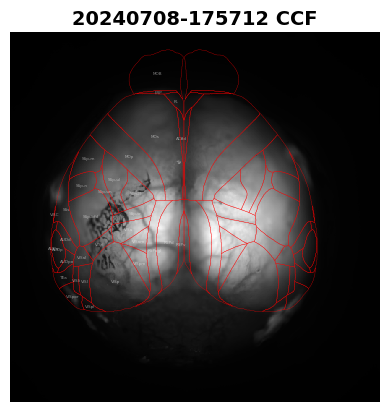

In [ ]:
# plot avg_frame & CCF

fig = plt.figure()
plt.imshow(frames_average[0], cmap='gray')
for i, r in ccf_regions_im.iterrows():
    plt.plot(r['left_x'], r['left_y'], 'r', lw=0.2)
    plt.plot(r['right_x'], r['right_y'], 'r', lw=0.2)
    plt.text(r.left_center[0], r.left_center[1], r.acronym, color='w', va='center', fontsize=3, alpha=0.5, ha='center')

plt.axis('off')
plt.title(experiment+' CCF')
fig.set_facecolor('white')
plt.show()


In [ ]:
X = tif_sort.reshape(tif_height*tif_width, -1).T
print('ICA dim:', X.shape)

ICA dim: (14000, 262144)


In [ ]:
k, IC, demix_matrix = LCC_ICA(X, min_IC=10, verbose=False)

IC_array = cp.asnumpy(IC.reshape(n_IC, *U.shape[:-1]))
mix_matrix = cp.asnumpy(cp.linalg.pinv(demix_matrix))

del X, demix_matrix, IC
cp._default_memory_pool.free_all_blocks()



test n_IC = 10


test n_IC = 11


test n_IC = 12


test n_IC = 13


test n_IC = 14


test n_IC = 15


test n_IC = 16


test n_IC = 17


test n_IC = 18


test n_IC = 19


test n_IC = 20


test n_IC = 21


test n_IC = 22


test n_IC = 23


test n_IC = 24


test n_IC = 25


test n_IC = 26


test n_IC = 27


test n_IC = 28


test n_IC = 29


test n_IC = 30


test n_IC = 31


test n_IC = 32


test n_IC = 33


test n_IC = 34


test n_IC = 35


test n_IC = 36


test n_IC = 37


test n_IC = 38


test n_IC = 39


test n_IC = 40


test n_IC = 41


test n_IC = 42


test n_IC = 43


test n_IC = 44


test n_IC = 45


test n_IC = 46


test n_IC = 47


test n_IC = 48


test n_IC = 49


test n_IC = 50


test n_IC = 51


test n_IC = 52


test n_IC = 53


test n_IC = 54


test n_IC = 55


test n_IC = 56


test n_IC = 57


test n_IC = 58


test n_IC = 59


test n_IC = 60


test n_IC = 61


test n_IC = 62


test n_IC = 63


test n_IC = 64


test n_IC = 65


test n_IC = 66


test n_IC = 67


test n_IC = 

KeyboardInterrupt: 

In [ ]:
def DW_ICA_GPU(X, min_IC=2, max_IC=None, nIC_step=1, verbose=False):
    N = X.shape[0]
    if max_IC == None: max_IC=N
    
    DW_values = []
    for n_IC in range(min_IC, max_IC, nIC_step):
        print(f'\ntest n_IC = {n_IC}')
        demix_matrix = jadeR_cupy(X, m=n_IC, verbose=verbose)
        IC = demix_matrix @ X
        Xk = cp.linalg.pinv(demix_matrix) @ IC
        Rk = cp.asnumpy(X - Xk)
        DW_sample_values = [calculate_DW(np.asarray(Rk[i, :]).ravel()) for i in range(N)]
        DW_values.append(DW_sample_values)
        print(f"DW: {DW_sample_values}")

        del demix_matrix, IC, Xk
        cp._default_memory_pool.free_all_blocks()

    IC_num = range(min_IC, max_IC, nIC_step)
    return IC_num, np.asarray(DW_values)

In [ ]:
IC_num, DW_values= DW_ICA_GPU(X, min_IC=5, max_IC=100, nIC_step=10, verbose=False)

DW_values_=np.hstack((np.asarray(IC_num).reshape(-1,1), DW_values))
np.savetxt(pjoin(path_out, 'DW_values.csv'), DW_values_, delimiter=",")

# DW_values_ = np.loadtxt(pjoin(path_out, 'DW_values.csv'), delimiter=",")
IC_num = DW_values_[:,0]
DW_values = DW_values_[:,1:]

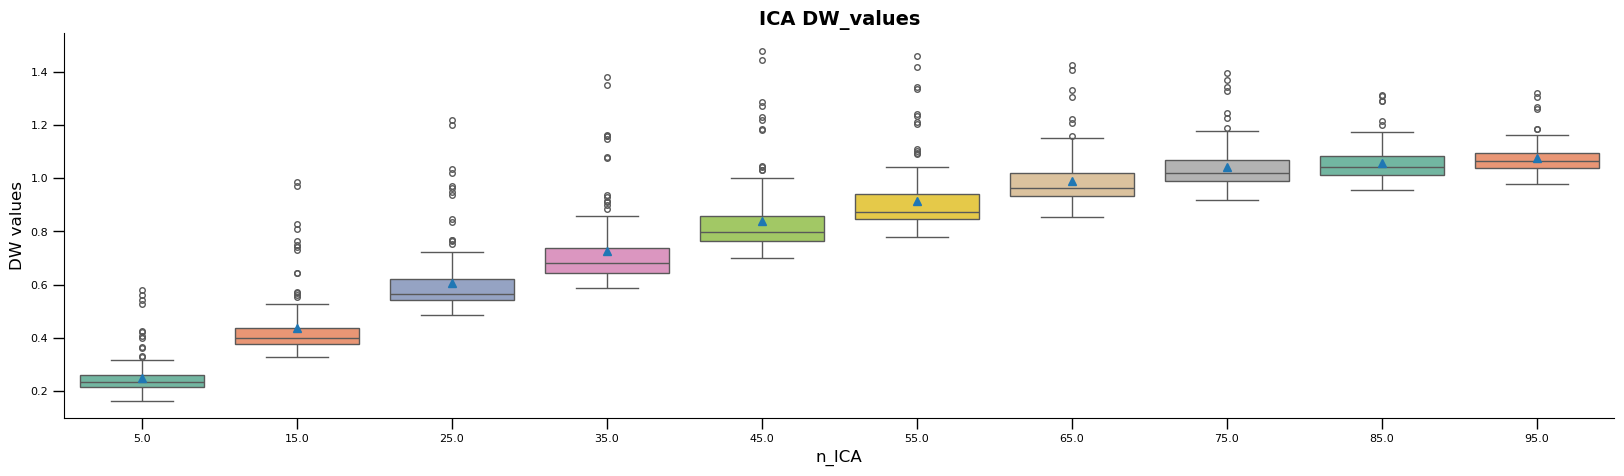

In [ ]:
import seaborn as sns
import pandas as pd

n_model,n_sample = DW_values.shape
DW_values_bin = DW_values.reshape(n_model, 100, n_sample//100).mean(axis=1)
df = pd.DataFrame(DW_values_bin.T)

fig = plt.figure(figsize=(20,5))
sns.boxplot(data=df, palette="Set2", showmeans=True)
# sns.stripplot(data=df, color="black", jitter=0.2, size=3)

plt.title('ICA DW_values')
plt.xlabel('n_ICA')
plt.ylabel('DW values')
plt.xticks(ticks=np.arange(len(IC_num)), labels=IC_num) 

fig.set_facecolor('white') 
plt.savefig(pjoin(path_out, 'ICA DW_values'), bbox_inches='tight')
plt.show()
